In [1]:
import pandas as pd
import string
import pymysql
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
import numpy as np
import warnings
warnings.filterwarnings("ignore")

Notebook realizado para o curso bootcamp Business inteligence da IGTI, aqui apresentarei como desenvolvi os processos de criação do banco de dados, ETL, EDA (análise exploratória dos dadoss) e a realização de previsões utilizando o modelo SARIMAX(nome genérico).

Estarei explorando e comentando as dificuldades que enfrentei durante todo o processo assim como qualquer outra observação que possuir


**Banco de dados:**

Foi utilizado o Mysql com auxílio do Mysqlworkbench, tanto para a modelagem, como para a criação doo banco.

O objetivo inicial era utilizar o mysql como um centralizador de dados, simulando um "cenário real", porém tive problemas na inserção de dados principalmente na tabela_fato(grande quantidade de dados)


**Tabela moeda** não tinha relacionamento com nenhuma outra, por esse motivo decidi excluí-la e utilizar todos os formatos como R$

**Tabela meta** veio fora de formato adequado, por esse motivo a solução encontrada foi dividí-la em 3 colunas. Canais, Datas e Valor (processo feito através do excel) **apesar de não ter utilizado a tabela ja deixei certa**

**inserção dos dados**
Se tratando de grande quantidades de linhas, não obtive sucesso para a inserção da tabela vendas por meio do csv, tentei via vba (sem sucesso, não consegui conectar ao banco de dados), tentei via criando um arquivo com inúmeros "inserts into..." também não deu certo, única maneira que consegui foi utilizando o python, por motivos de performance e para dar continuidade ao trabalho, só como demonstração irei inserir uma quantidade de dados menores mas utilizarei o arquivo completo ja em csv

obs: A minha intenção é simular um ambiente real, e por motivos de aprendizado estarei realizando a conexão também no mysql.

**Nunca trabalhei na área de BI, todo meu conhecimento foi através de cursos, faculdade e a pós graduação, qualquer dúvida, sugestão de melhoria é sempre bem vinda.** 

**Lembro ainda que a programação nunca é o FIM, sempre é o MEIO para se obter a informação, ou seja, não importa a ferramenta, mas sim o resultado que alcançara.**


Segue como ficou a modelagem:

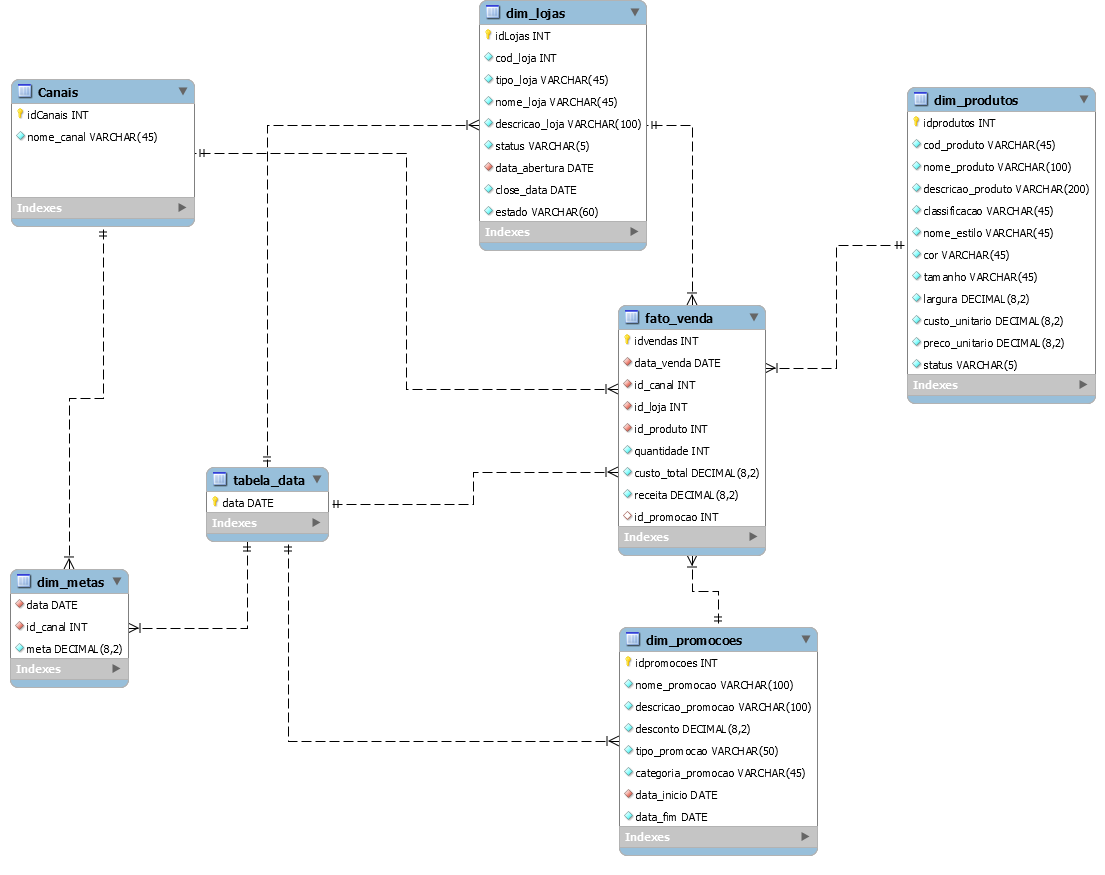

In [65]:
from IPython.display import Image
Image("modelagem.png")


In [2]:
dataset = pd.read_csv("dim_vendas1.csv", sep=";")

**Função para a conexão com o MySQLServer e inserção dos dados**:

In [3]:
# Connect to the database
def insert_values(dataset,range_):
    i=0
    connection = pymysql.connect(host='localhost',
                                 user='leozanellato',
                                 password='leozanellato',
                                 db='igti',
                                 charset='utf8mb4',
                                 cursorclass=pymysql.cursors.DictCursor)

    for i in range(range_):
        idvenda = dataset.loc[i][0]
        data = dataset.loc[i][1]
        idcanal = dataset.loc[i][2]
        idloja = dataset.loc[i][3]
        idproduto =  dataset.loc[i][4]
        idquantidade =  dataset.loc[0][5]
        custo = dataset.loc[i][6]
        receita = dataset.loc[i][7]
        id_promocao = dataset.loc[i][8]

        try:

            cursor = connection.cursor()
            cursor.execute(f"INSERT INTO fato_venda (idvendas,data_venda,id_canal,id_loja,id_produto,quantidade,custo_total,receita,id_promocao) VALUES ({idvenda},'{data}',{idcanal},{idloja},{idproduto},{idquantidade},{custo},{receita},{id_promocao});")
            i= i+1
        except:
            print(f"erro na linha {i}")
                 
    connection.commit()
    connection.close()
    print("Dados inseridos")

Não sei por qual motivo alguns dados não foram inseridos, conforme segue abaixo, entretanto, como só estou demonstrando  acredito que não terá nenhum problema. As outras análises estarei utilizando o banco de dado completo

Nos procedimentos abaixo, alem da inserção de 1000 linhas, realizei um select apenas para reforçar o aprendizado, também conferi os dados para ver se realizei o select de forma correta

In [4]:
insert_values(dataset,1000)

erro na linha 27
erro na linha 63
erro na linha 332
erro na linha 958
Dados inseridos


In [5]:
connection = pymysql.connect(host='localhost',
                                 user='leozanellato',
                                 password='leozanellato',
                                 db='igti',
                                 charset='utf8mb4',
                                 cursorclass=pymysql.cursors.DictCursor)
cursor = connection.cursor()


cursor.execute("SELECT dim_produtos.nome_produto, dim_lojas.nome_loja, fato_venda.custo_total FROM fato_venda INNER JOIN dim_lojas ON fato_venda.id_loja = dim_lojas.idlojas INNER JOIN dim_produtos ON fato_venda.id_produto = dim_produtos.idprodutos WHERE fato_venda.custo_total = 48.93 and fato_venda.receita = 92.8 and fato_venda.idvendas=173" )
# Recupera o resultado:
resultado = cursor.fetchall()

# Mostra o resultado:
print('Resultado: ')

for linha in resultado :
    print(linha)

# Finaliza a conexão
connection.close()

Resultado: 
{'nome_produto': 'MGS Bicycle Card Games2009 E166', 'nome_loja': 'Contoso North America Online Store', 'custo_total': Decimal('48.93')}


In [6]:
dataset[(dataset["Custo Total"]==48.93) & (dataset["Receita"]==92.8) & (dataset["IDVendas"]==173) ]

,IDVendas,Data Venda,IDCanal,IDLoja,IDProduto,Quantidade,Custo Total,Receita,id_promocao
172,173,2007-09-10,2,199,1810,3,48.93,92.8,1


Bom, começaremos agora as análises... as questões do enunciado são:

1. Qual canal gerou mais receita nos três anos?
2. Qual canal cresceu mais em vendas nos três anos? 
3. Existe alguma sazonalidade no comportamento das vendas?

Ao final do projeto seremos capazes de além de responder essas questões, alencar outras questões presentes no desafio existente no fórum, além de realizar previsões de meses futuros.

O correto seria eu fazer toda a análise exploratória dos dados, para depois realizar as previsões. Mas pelo motivo de que primeiro elaborei o notebook para depois responder as questões do desafio, deixarei as questões do desafio por último

**Tratamento dos dados:**



In [7]:
fato_venda = pd.read_csv("dim_vendas1.csv", sep =";", parse_dates=["Data Venda"],decimal='.')
dim_canais = pd.read_csv("dim_canais.csv", sep=";")
dim_lojas = pd.read_csv("dim_lojas.csv", sep=";", parse_dates=["Data_Abertura", "Data_Fechamento"])
dim_metas = pd.read_csv("dim_metas.csv", sep=";", parse_dates=["Data"])
dim_produtos= pd.read_csv("dim_produtos.csv", sep=";", decimal=".")
dim_promocoes = pd.read_csv("dim_promocoes.csv", sep=";", parse_dates=["DataInicio", "DataFim"], decimal=".")

In [8]:
full_data = pd.merge(fato_venda,dim_promocoes, left_on="id_promocao", right_on="IDPromocao")
full_data = pd.merge(full_data,dim_produtos, left_on="IDProduto", right_on="IDProduto")
full_data = pd.merge(full_data,dim_lojas, left_on="IDLoja", right_on="IDLoja")
full_data = pd.merge(full_data,dim_canais, left_on="IDCanal", right_on="IDCanal")

In [9]:
dataset_ = full_data[["Data Venda","IDCanal","Nome Canal", "Quantidade", "Custo Total", "Receita", "NomeProduto", "DescricaoProduto","Nome_Loja"]]

In [10]:
df = dataset_.copy()

In [11]:
df.head()

,Data Venda,IDCanal,Nome Canal,Quantidade,Custo Total,Receita,NomeProduto,DescricaoProduto,Nome_Loja
0,2007-01-02,1,Store,8,728.40,1544.40,A. Datum Point Shoot Digital Camera M500 Black,gital camera. digital camera - compact. 3.7 in...,Contoso Baildon Store
1,2007-03-05,1,Store,6,60.90,115.22,Contoso Battery charger - bike E200 Black,Primary extended capacity battery pack -for bike,Contoso Baildon Store
2,2007-10-11,1,Store,8,1672.24,3034.00,Fabrikam Budget Moviemaker 2/3'' 17mm E100 White,Standard definition,Contoso Baildon Store
3,2007-01-24,1,Store,8,1063.20,2312.00,The Phone Company Touch Screen Phones 4-Wire/O...,3G-enabled touch screen phone in ice blue with...,Contoso Baildon Store
4,2008-10-30,1,Store,8,930.30,2312.00,The Phone Company Touch Screen Phones 4-Wire/O...,3G-enabled touch screen phone in ice blue with...,Contoso Baildon Store


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048575 entries, 0 to 1048574
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Data Venda        1048575 non-null  datetime64[ns]
 1   IDCanal           1048575 non-null  int64         
 2   Nome Canal        1048575 non-null  object        
 3   Quantidade        1048575 non-null  int64         
 4   Custo Total       1048575 non-null  float64       
 5   Receita           1048575 non-null  float64       
 6   NomeProduto       1048575 non-null  object        
 7   DescricaoProduto  1048136 non-null  object        
 8   Nome_Loja         1048575 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 80.0+ MB


In [13]:
receita = df.groupby("IDCanal").agg({"Receita":"sum"})

Resposta da questão 1: O canal 1 foi o que mais trouxe receita para a empresa durante os 3 anos

Text(0.5, 0, 'Canal')

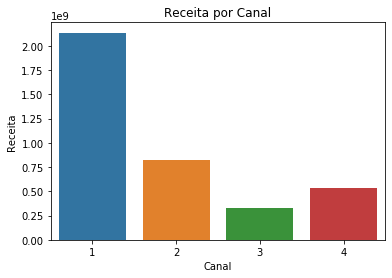

In [14]:
plt.title("Receita por Canal")
sns.barplot(x=receita.index, y=receita["Receita"])
plt.xlabel("Canal")

In [15]:
full_valor = df[["Quantidade", "Custo Total", "Receita", "Data Venda"]].groupby(by="Data Venda").sum()

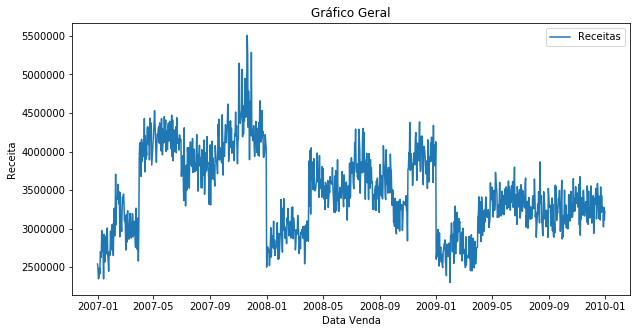

In [16]:
plt.figure(figsize=(10,5))
plt.title("Gráfico Geral")
sns.lineplot(full_valor.index, full_valor["Receita"], label="Receitas")

In [17]:
canal1 = df[df["IDCanal"]==1][["Data Venda","Receita"]].groupby(by="Data Venda").sum()
canal2 = df[df["IDCanal"]==2][["Data Venda","Receita"]].groupby(by="Data Venda").sum()
canal3 = df[df["IDCanal"]==3][["Data Venda","Receita"]].groupby(by="Data Venda").sum()
canal4 = df[df["IDCanal"]==4][["Data Venda","Receita"]].groupby(by="Data Venda").sum()

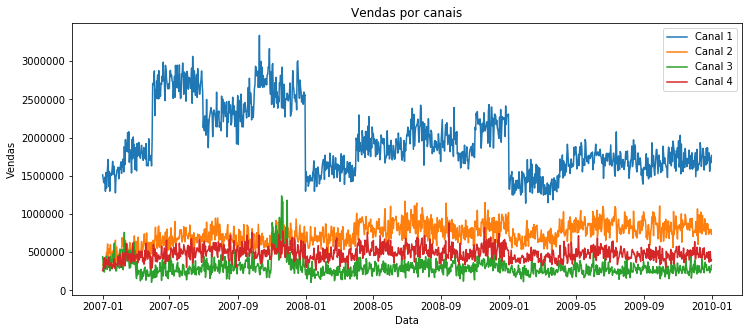

In [18]:
plt.figure(figsize=(12,5))
plt.title("Vendas por canais")
plt.plot(canal1.index,canal1["Receita"],label="Canal 1")
plt.plot(canal2.index,canal2["Receita"],label="Canal 2")
plt.plot(canal3.index,canal3["Receita"],label="Canal 3")
plt.plot(canal4.index,canal4["Receita"],label="Canal 4")
plt.ylabel("Vendas")
plt.xlabel("Data")
plt.legend()

In [19]:
crescimento1 = df.groupby([df["IDCanal"],df['Data Venda'].dt.year]).sum()

Resposta da questão 2:
O canal 2 foi o que teve o maior crescimento durante os 3 anos, e o canal 1 o que menos teve crescimento (na verdade reduziu as vendas)


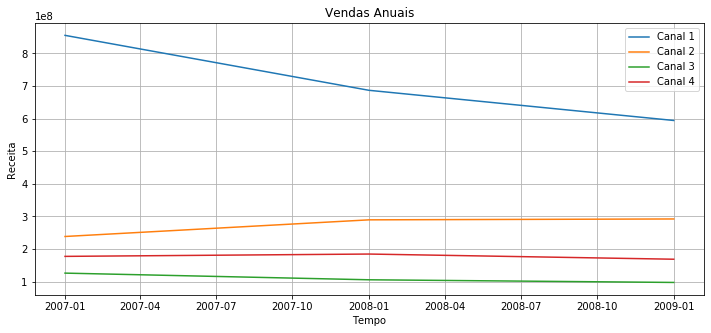

In [20]:
tempo = pd.to_datetime(["2007","2008","2009"])
plt.figure(figsize=(12,5))
plt.title("Vendas Anuais")
sns.lineplot(tempo,crescimento1.loc[1]["Receita"],label="Canal 1")
sns.lineplot(tempo,crescimento1.loc[2]["Receita"], label="Canal 2")
sns.lineplot(tempo,crescimento1.loc[3]["Receita"], label="Canal 3")
sns.lineplot(tempo,crescimento1.loc[4]["Receita"], label="Canal 4")
plt.xlabel("Tempo")
plt.grid()

In [21]:
df["mes-ano"] = df["Data Venda"].apply(lambda x: str(x))
df["mes-ano"] = df["mes-ano"].apply(lambda x: x[:7])
mes = df.groupby(by="mes-ano").sum()
mes.index = pd.to_datetime(mes.index)
mes.index.freq = "MS"
full_valor.index.freq = "d"
results = seasonal_decompose(full_valor["Receita"],model="add")

Para responder a questão 3, farei a implantação do modelo SARIMAX, e em consequência utilizarei o modelo para a previsão de vendas

In [22]:
full_valor.head()

,Quantidade,Custo Total,Receita
Data Venda,,,
2007-01-01,11004,1135820.66,2541135.75
2007-01-02,11081,1105049.53,2478645.29
2007-01-03,11298,1048706.04,2348880.37
2007-01-04,11039,1037314.70,2371158.66
2007-01-05,11300,1100181.53,2485010.53


Como os dados estão agrupados por dia de venda, podemos verificar que a Sazonalidade está quase ilegível, porém vamos dar continuidade

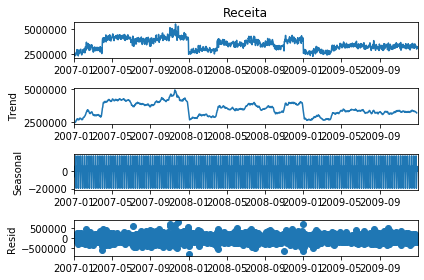

In [23]:
results.plot();

Ao darmos um "zoom" ao gráfico de sazonalidade, podemos ver que claramente existe uma sazonalidade semanal, provavelmente aos finais de semana, 7 de janeiro é um domingo, podemos concluir então que aos domingos as vendas são menores

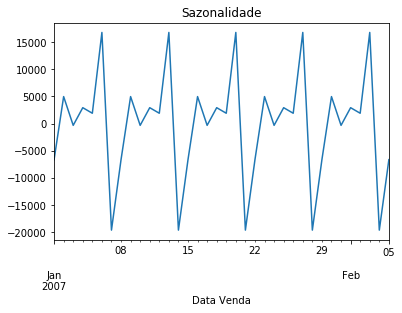

In [24]:
plt.title("Sazonalidade")
results.seasonal.iloc[:36].plot()

**Devemos agora verifricar a sazonalidade mensal** (será que existem meses que vendem mais do que outros?)

Aparentemente sim, ao plotarmos o gráfico podemos ver com uma maior facilidade que realmente existe sazonalidade, sendo que os meses de pico são os de novembro/dezembro, e os de queda são os meses de janeiro e fevereiro

Vale ressaltar que ainda podemos verificar a tendência que está em queda e também o residuo (tudo aquilo que não pode ser explicado tanto pela tendência quanto pela sazonalidade)

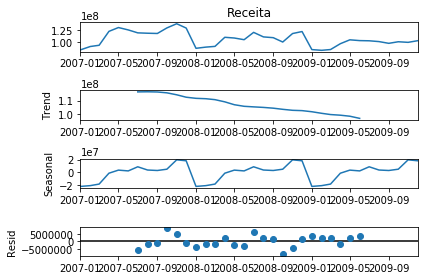

In [25]:
mensal = seasonal_decompose(mes["Receita"], model="add")
mensal.plot();

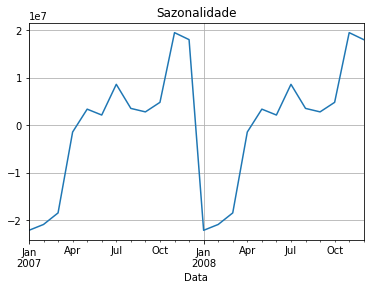

In [26]:
mensal.seasonal.iloc[:24].plot()
plt.title("Sazonalidade")
plt.xlabel("Data")
plt.grid()

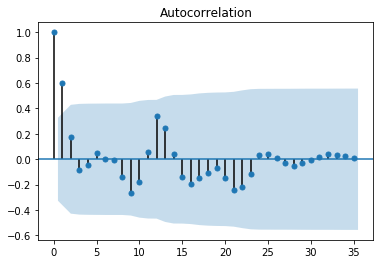

In [27]:
plot_acf(mes["Receita"], lags=35);

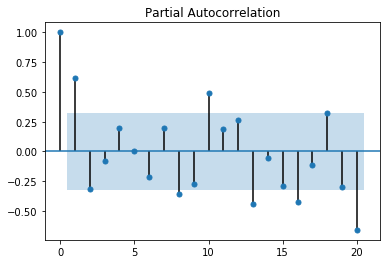

In [28]:
plot_pacf(mes["Receita"], lags=20);

A seguir devemos então verificar se a série é **estacionária ou não**, para isso é utilizaremos o **teste do adfuller**

O seguinte teste retornará uma tupla de estatísticas do teste do ADF, como Estatística do teste Valor-P; Número de defasagens usadas; Número de observações usadas para a regressão do ADF e um dicionário de Valores críticos.

Resumindo, se o valor-p encontrado pelo teste for < 0,05, a série é estacionária, ja se o valor for acima de 0,05 a série não é estacionária e por esse motivo devemos então normaliza-la.

Utilizei uma função para simplificar a visualização dos valores, e o valor p encontrado foi inferior a 0,05, sendo assim, a série é estacionária, podemos então dar continuidade aos projetos

Se tratando de um modelo que é muito difícil de interpretar os gráficos (mesmo para o especialistas), e se tratando do fato que sou nível "usuário" de estatística, aplicarei o autoarima que identificará os melhores parâmetros sem perca de tempo

In [29]:
# função criada para uma melhor visualização dos resultados do adfuller test
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [30]:
adf_test(full_valor["Receita"])

Augmented Dickey-Fuller Test: 
ADF test statistic        -3.217050
p-value                    0.019019
# lags used                6.000000
# observations          1089.000000
critical value (1%)       -3.436369
critical value (5%)       -2.864198
critical value (10%)      -2.568185
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


**Começaremos agora o processamento de dados para a realização das projeções e treinamento do modelo de machine learning**
Pressupostos:

    Dataset está dividido em 36 meses de vendas, dividirei ele tem dataset de treino e dataset de test.
    Defini que estarei utilizando apenas meses agrupados para a realização das previsões, porém futuramente estarei realizando testes com o dataset agrupado semanalmente para ver se encontro melhores soluções
    Dataset de treino será composto pelos primeiros 24 meses, dataset de teste o restante
    Primeiramente só estarei verificando como o modelo se comportará
    Para diminuir a variância dos dados, sempre é bom "normalizar" os dados por esse motivo estarei utilizando a normalização via log com a função np.log
    

In [31]:
train = mes.iloc[:24]
test = mes.iloc[24:]
start = len(train) 
end = len(train) + len(test) -1

In [32]:
train.head()

,IDCanal,Quantidade,Custo Total,Receita
mes-ano,,,,
2007-01-01,54748,353770,3.610573e+07,8.277918e+07
2007-02-01,52700,356792,3.930679e+07,8.993302e+07
2007-03-01,55952,357714,4.053745e+07,9.259176e+07
2007-04-01,64065,477738,5.286632e+07,1.223446e+08
2007-05-01,65890,484376,5.614194e+07,1.305294e+08


In [33]:
sarima = auto_arima(np.log(mes['Receita']),seasonal=True,trace=True, m=12)

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(1,0,1,12) [intercept=True]; AIC=-53.049, BIC=-40.381, Time=0.849 seconds
Fit ARIMA(0,0,0)x(0,0,0,12) [intercept=True]; AIC=-32.923, BIC=-29.756, Time=0.026 seconds
Fit ARIMA(1,0,0)x(1,0,0,12) [intercept=True]; AIC=-59.218, BIC=-52.884, Time=0.477 seconds
Fit ARIMA(0,0,1)x(0,0,1,12) [intercept=True]; AIC=-53.889, BIC=-47.555, Time=0.332 seconds
Near non-invertible roots for order (0, 0, 1)(0, 0, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,0,0)x(0,0,0,12) [intercept=False]; AIC=314.121, BIC=315.705, Time=0.006 seconds
Fit ARIMA(1,0,0)x(0,0,0,12) [intercept=True]; AIC=-47.559, BIC=-42.809, Time=0.084 seconds
Fit ARIMA(1,0,0)x(2,0,0,12) [intercept=True]; AIC=-45.688, BIC=-37.771, Time=1.326 seconds
Fit ARIMA(1,0,0)x(1,0,1,12) [intercept=True]; AIC=-55.153, BIC=-47.235, Time=0.444 seconds
Fit ARIMA(1,0,0)x(0,0,1,12) [intercept=True]; AIC=-56.501, BIC=-50.16

**MODELO SARIMA**

De uma forma resumida, o ARIMA model é composto por:

AR(p) = Autoregression model, prevemos utilizando a combinação de valores passados da próprima variável. Gera modelos lineares. Representado pela letra P MA(d) = é o modelo de média móvel. ARMA(p,q) = A junção dos dois acima - representado pela letra Q ARIMA(p,q,d) = O mesmo processo que ocorre para o ARMA + aplicação da diferenciação para tornar a série estacionária.

Temos então o SARIMAX (termo genérico), além dos parâmetros (p,q,d) aceita também o (P,D,Q)m, descrevendo os componentes sazonais. P,D e Q representa a regressão sazonal, diferenciação, e média movel, m representa o número de pontos para cada ciclo.

O X representa a variável exógena, como não utilizaremos ela, não entrarei em maiores detalhes.

Para a definição dos melhores parâmetros existe a forma manual e a forma automática, onde a função definirá os melhores parâmetros para nós...

Função: Auto_arima, devo informar ainda o meu dataset, definir os pontos de start do "p" e do "q", definir a sazonalidade e o período de sazonalidade, no caso são de 12 meses.

O objetivo é achar os melhores parâmetros em base no valor AIC, que deve ser o menor possível, com a menor complexidade

In [34]:
sarima

ARIMA(maxiter=50, method='lbfgs', order=(1, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(1, 0, 0, 12),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

Melhores parâmetros: order=(1, 0, 0) e seasonal_order=(1, 0, 0, 12)

In [35]:
model = SARIMAX(np.log(train['Receita']), order=(1, 0, 0),seasonal_order=(1, 0, 0, 12)).fit()

In [36]:
predictions = model.predict(start,end,typ="levels")
predictions = np.exp(predictions)

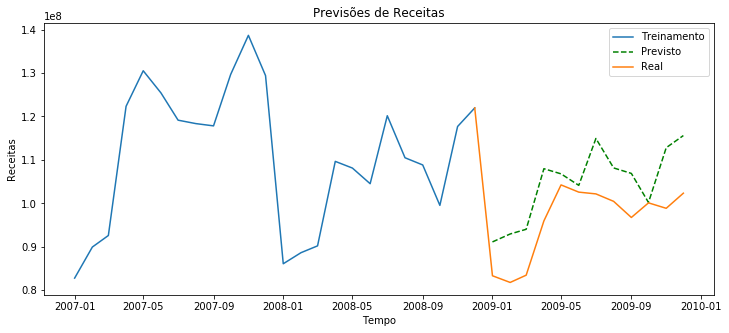

In [37]:
plt.figure(figsize=(12,5))
plt.title("Previsões de Receitas")
plt.plot(train["Receita"], label="Treinamento")
plt.plot(predictions, label="Previsto", color="green", linestyle="dashed")
plt.plot(mes["Receita"][23:], label="Real")
plt.xlabel("Tempo")
plt.ylabel("Receitas")
plt.legend()

Verificando as previsções, podemos afirmar que o modelo seguiu a tendência(principalmente nos primeiros meses) e além de chegar muito próximo do real em outros meses... Lembrando que por enquanto estamos apenas treinando o modelo e verificando a sua eficácia.

Após treinado o modelo, podemos então realizar as previsões futuras. Lembrando que para realizar o treinamento para reduzir a variância, transformei os dados em base log (conforme utilizado o np.log), depois eu o expandi novamente para verificar na base de dados. Podemos concluir que o modelo acompanhou a tendência chegando muito próximo ao real. Agora podemos realizar o treinamento com o dataset inteiro e depois realizar predições futuras.

In [38]:
from statsmodels.tools.eval_measures import rmse, mse

In [39]:
media_test = test["Receita"].mean()
rmse_model = rmse(test["Receita"], predictions)
print(f" o RMSE foi de {round(rmse_model,2)} o que representa {round((rmse_model/media_test) * 100,2)}% da média no mesmo período")

 o RMSE foi de 9772731.58 o que representa 10.18% da média no mesmo período


Vale lembrar que a projeção acompanhou a tendência, além de em alguns meses os valores terem alcançado valores muitos proximos

In [40]:
start = len(mes["Receita"]) -1
end = len(mes["Receita"]) + 6

In [41]:
model = SARIMAX(np.log(mes['Receita']), order=(1, 0, 1),seasonal_order=(0, 0, 1, 12)).fit()
predictions_final = model.predict(start,end,typ="levels")
predictions_final = np.exp(predictions_final)

**Com o modelo treinado, podemos então realizar as predições dos próximos 6 meses**

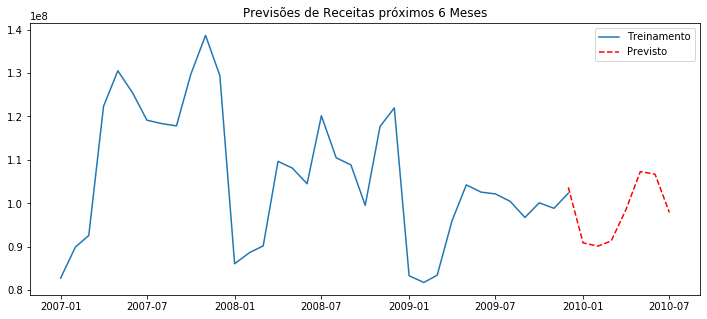

In [42]:
plt.figure(figsize=(12,5))
plt.title("Previsões de Receitas próximos 6 Meses")
plt.plot(mes["Receita"], label="Treinamento")
plt.plot(predictions_final,color = "red", linestyle="dashed", label="Previsto")
plt.legend()

In [43]:
full_data.to_csv("full_data.csv") #enviando o dataset formatado caso queira usar no powerBI

**Vamos agora para as respostas do desafio, aqui é onde podemos receber vários insights para a tomada de decisão!!**

In [44]:
df["Trimestre"] = df["Data Venda"].dt.quarter
df["Ano"] = df["Data Venda"].dt.year

In [45]:
#Qual canal gerou mais receita nos três anos? (questão ja respondida anteriormente, porém novamente: Canal 1)
questao1 = df.groupby(["IDCanal"]).sum()
questao1

,Quantidade,Custo Total,Receita,Trimestre,Ano
IDCanal,,,,,
1,8943114,9.209404e+08,2.136442e+09,1692580,1345180279
2,3825010,3.563618e+08,8.196063e+08,488071,387742964
3,1368697,1.418121e+08,3.285074e+08,149135,119664887
4,2242747,2.300116e+08,5.300973e+08,317097,252770994


In [46]:
# Quantos canais de vendas existem na base?  Resposta:4

In [47]:
len(dataset)#Quantas vendas foram realizadas no total em todos os anos? 

1048575

In [48]:
dataset["Receita"].sum()

3814653500.899998

In [49]:
# Quantas vendas foram realizadas pelo Canal 2 no 1º trimestre de 2009? 
df[(df["IDCanal"] == 2) & (df["Ano"]==2009) & (df["Trimestre"]==1)]["Receita"].count()

14153

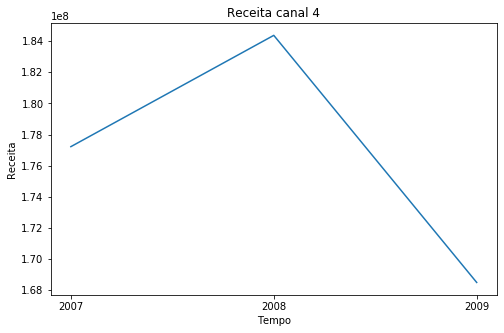

In [50]:
#6 Em qual ano o Canal 4 teve maior receita? Resposta: 2008
questao6 = df.groupby(["IDCanal","Ano"]).sum().loc[4]
plt.figure(figsize=(8,5))
plt.title("Receita canal 4")
plt.xlabel("Tempo")
sns.lineplot(x=["2007", "2008", "2009"],y=questao6["Receita"])

In [51]:
df["Receita"].sum()#7 Qual foi a receita total dos canais em todos os anos? 

3814653500.8999996

In [52]:
#8 Qual foi a receita do Canal 2 no 2º trimestre de 2009? (no forum ta 1º trimestre) 
questao8 = df[df["IDCanal"]==2].groupby(by=["Ano","Trimestre"])["Receita"].sum()
questao8.loc[2009].loc[2]

77051625.90999846

In [53]:
#9 - Qual foi o trimestre que o Canal 4 teve maior quantidade de vendas em todos os anos? 
questao9 = df[df["IDCanal"]==4].groupby(by=["Ano","Trimestre"])["Data Venda"].count()

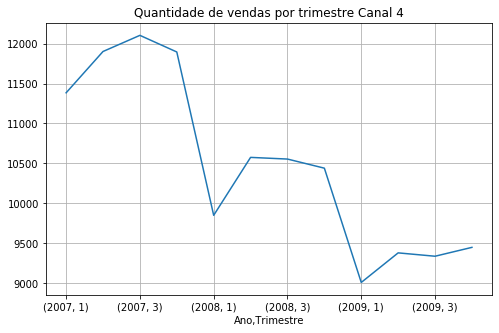

In [54]:
plt.figure(figsize=(8,5))
plt.title("Quantidade de vendas por trimestre Canal 4")
questao9.plot()
plt.grid()

In [55]:
#10 - Qual foi a quantidade de vendas realizadas pelo Canal 4 no trimestre em que mais vendeu, considerando todos os anos? 
questao10 = df[df["IDCanal"]==4].groupby(by=["Ano","Trimestre"])["Data Venda"].count().max()
questao10

12103

In [56]:
#11 Em qual ano o Canal 1 teve um custo total mais baixo?
questao11 = df[df["IDCanal"]==1].groupby(by=["Ano"])["Custo Total"].count()
questao11

Ano
2007    314422
2008    198778
2009    156789
Name: Custo Total, dtype: int64

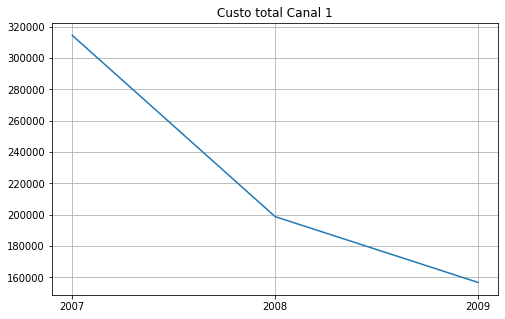

In [57]:
plt.figure(figsize=(8,5))
plt.title("Custo total Canal 1")
plt.plot(["2007", "2008", "2009"],questao11)
plt.grid()

In [58]:
#12 - Qual está sendo o custo total da Contoso, considerando todos os canais e todos os anos? 
df["Custo Total"].sum()

1649125866.5499997

In [59]:
# Qual é o canal teve o menor custo em 2009? 
questao13 = df.groupby(["Ano","IDCanal"]).sum().loc[2009]
questao13
#questao13[questao13["Custo Total"]== min(questao13["Custo Total"])]

,Quantidade,Custo Total,Receita,Trimestre
IDCanal,,,,
1,2994241,2.576775e+08,5.942360e+08,397742
2,1709209,1.274853e+08,2.920246e+08,154588
3,500104,4.208215e+07,9.724083e+07,45080
4,899966,7.345417e+07,1.685011e+08,93590


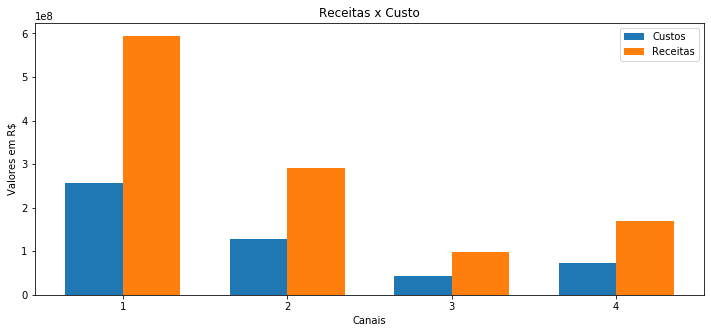

In [60]:
labels = questao13.index
custos = questao13["Custo Total"]
receitas = questao13["Receita"]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,5))
rects1 = ax.bar(x - width/2, custos, width, label='Custos')
rects2 = ax.bar(x + width/2, receitas, width, label='Receitas')

ax.set_ylabel('Valores em R$')
ax.set_title('Receitas x Custo')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel("Canais")
ax.legend()


Demais questões aguardarei a resposta na aula pois os valores não estão batendo...

In [61]:
dataset["custo unitario"] = dataset["Custo Total"]/dataset["Quantidade"]

In [62]:
dataset[dataset["custo unitario"] == max(dataset["custo unitario"])].head()

,IDVendas,Data Venda,IDCanal,IDLoja,IDProduto,Quantidade,Custo Total,Receita,id_promocao,custo unitario
560,561,2008-08-22,1,194,1945,12,12722.64,38399.88,1,1060.22
966,967,2008-02-25,1,97,1951,9,9541.98,28319.91,1,1060.22
1423,1424,2008-09-27,1,301,1963,10,10602.20,31999.90,1,1060.22
1430,1431,2008-06-04,1,264,1951,12,12722.64,37439.88,1,1060.22
2634,2635,2009-08-10,2,199,1957,12,12722.64,37119.88,1,1060.22


In [63]:
dim_produtos[dim_produtos["custo_unitario"]==max(dim_produtos["custo_unitario"])].head()

,IDProduto,CodProduto,NomeProduto,DescricaoProduto,classificacao,Nome_Estilo,Cor,Tamanho,Largura,custo_unitario,preco_unitario,Status
769,1897,802001,Fabrikam Refrigerator 24.7CuFt X9800 White,Total capacity: 24.7cu.ft. Dispense-a-Can stor...,Deluxe,Product0802001,White,21.6 x 18.1 x 46.1,71.0,1060.22,3199.99,On
770,1903,802007,Fabrikam Refrigerator 24.7CuFt X9800 Brown,Total capacity: 24.7cu.ft. Dispense-a-Can stor...,Deluxe,Product0802007,Brown,20.8 x 19.9 x 18.8,56.8,1060.22,3199.99,On
771,1909,802013,Fabrikam Refrigerator 24.7CuFt X9800 Silver,Total capacity: 24.7cu.ft. Dispense-a-Can stor...,Deluxe,Product0802013,Silver,35.8 x 39.2 x 27,209.0,1060.22,3199.99,On
772,1915,802019,Fabrikam Refrigerator 24.7CuFt X9800 Green,Total capacity: 24.7cu.ft. Dispense-a-Can stor...,Deluxe,Product0802019,Green,18.3 x 19.3 x 20.2,38.1,1060.22,3199.99,On
773,1921,802025,Fabrikam Refrigerator 24.7CuFt X9800 Blue,Total Capacity: 24.7cu.ft. Dispense-a-Can stor...,Deluxe,Product0802025,Blue,20.7 x 18.7 x 33.7,75.0,1060.22,3199.99,On


In [64]:
dim_produtos[dim_produtos["custo_unitario"]==min(dim_produtos["custo_unitario"])]

,IDProduto,CodProduto,NomeProduto,DescricaoProduto,classificacao,Nome_Estilo,Cor,Tamanho,Largura,custo_unitario,preco_unitario,Status
122,919,308177,SV USB Data Cable E600 Pink,A single. standardized and easy way to connect...,Economy,Product0308177,Pink,0,0.0,0.48,0.95,On
123,920,308178,SV USB Data Cable E600 Black,A single. standardized and easy way to connect...,Economy,Product0308178,Black,0,0.0,0.48,0.95,On
124,921,308179,SV USB Data Cable E600 Silver,A single. standardized and easy way to connect...,Economy,Product0308179,Silver,0,0.0,0.48,0.95,On
125,922,308180,SV USB Data Cable E600 Grey,A single. standardized and easy way to connect...,Economy,Product0308180,Grey,0,0.0,0.48,0.95,On
